In [1]:
using JLD2 # for saving and loading data
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using QuasiMonteCarlo # for LHS
using Optimization, OptimizationOptimJL, LineSearches # for optimization
using Trapz	 
using DataFrames, CSV # for data handling
using StatsBase


# include
include("./EDES/including.jl")

# set random seed
Random.seed!(1234);



# Load the synthetic meal response data

In [2]:
data = load("Results/SyntheticPatientsOutputs_2024-07-31-17_06.jld2")

# extract meal response data
glc = data["glucose"];
ins = data["insulin"];

time_G = data["time_G"];
time_I = data["time_I"];

IDs = data["ID"];
Health = data["Health"];

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0



75000.0

In [59]:
data

Dict{String, Any} with 7 entries:
  "ID"      => [1.0 1.0 1.0 1.0; 2.0 2.0 2.0 2.0; … ; 99.0 99.0 99.0 99.0; 100.…
  "glucose" => [5.15203 6.90472 … 5.04094 5.05393; 5.57861 7.78542 … 5.45034 5.…
  "Health"  => [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.0, 1.0, …
  "time_I"  => [0, 15, 30, 60, 120, 240]
  "insulin" => [9.84815 70.1658 … 15.8767 10.0903; 8.20958 83.6763 … 27.3589 20…
  "BW"      => 70
  "time_G"  => [0, 15, 30, 60, 120, 180, 240]

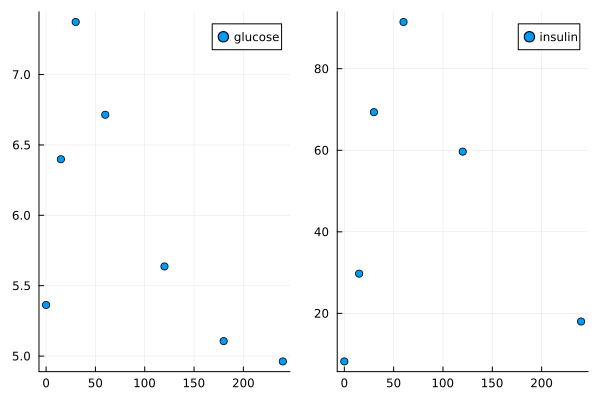

In [3]:
person = 1
meal_test = 1
scatter([time_G, time_I], [glc[meal_test,:,person], ins[meal_test,:,person]], layout = (1,2), label=["glucose" "insulin"],)

In [4]:
include("./EDES/including.jl")
columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

parameter_df = DataFrame([name => [] for name in columnnames])
patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
best_parameters_list = []
for i in 1#:size(IDs, 1)
    best_parameters = ParameterEstimation(patients[i]...)
    push!(best_parameters_list, best_parameters)
end

# plot output of the model with the best parameters
best_parameters = best_parameters_list[1]
println(best_parameters)


Optimization successful for this initial set, continuing...
Parameter estimation done!
[0.0029891896196758854, 0.020355523918411948, 9.496485496423357, 0.0002564794349524257]


In [ ]:
model = 

# Fit the EDES model


In [62]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0


if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("./EDES/including.jl")
end

columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]
# estimated_parameters = ["k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
results = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# initialise the dataframe
df_fits = DataFrame()
for col in columnnames
    df_fits[!, Symbol(col)] = Float64[]
end

# Flatten the IDs matrix into a vector
IDs_vec = vec(IDs')
# Repeat the Health vector n times to match the length of IDs_vec
Health_vec = repeat(Health, inner = n_meal_tests)
# Create a vector for meal test numbers
meal_tests = repeat(1:n_meal_tests, size(IDs)[1])

for i in 1:length(IDs_vec)
    # Add the meal test number, health status, and ID to the start of the result vector
    prepend!(results[i], [IDs_vec[i], meal_tests[i], Health_vec[i]])
end

# Fill the dataframe with the results
for i in 1:length(results)
    println(results[i])
    push!(df_fits, transpose(results[i]))
end

      From worker 14:	Optimization successful for this initial set, continuing...
      From worker 14:	Parameter estimation done!
      From worker 12:	Optimization successful for this initial set, continuing...
      From worker 16:	Optimization successful for this initial set, continuing...
      From worker 12:	Parameter estimation done!
      From worker 16:	Parameter estimation done!
      From worker 13:	Optimization successful for this initial set, continuing...
      From worker 13:	Parameter estimation done!
      From worker 10:	Optimization successful for this initial set, continuing...
      From worker 10:	Parameter estimation done!
      From worker 11:	Optimization successful for this initial set, continuing...
      From worker 11:	Parameter estimation done!
      From worker 15:	Optimization successful for this initial set, continuing...
      From worker 15:	Parameter estimation done!
      From worker 14:	Optimization successful for this initial set, continuing...
 

In [ ]:
df_fits

In [ ]:
#save the outputs
date_str = Dates.format(now(), "yyyy-mm-dd")
time_str = Dates.format(now(), "HH_MM")
date_time_str = date_str * "-" * time_str
file_name = "./Results/Synthetic_population_fits_$date_time_str.csv"

CSV.write(filename, df_fits)